# 序列到序列学习
最早用作机器翻译，给定一个源语言的句子，自动翻译成目标语言<br>
这两个句子可以有不同长度<br>
<img src='./image/seq2seq.jpg' alt='seq2seq' width=400><br>

双向RNN可以做decoder不能做encoder, 前一个rnn的hidden state作为decoder的初始状态<br>

注意到encoder的hidden state不仅要做初始隐藏状态,还会和decoder初始的输入做一次embedding送入网络<br>
<img src='./image/seqEn-De.jpg' alt='seqEn-De' width=400><br>

## 训练和推理
<img src='./image/trainPred.jpg' alt='seqEn-De' width=400><br>
训练时给出的是真实的输出(标签),推理时使用的是上一时刻的输出

## 衡量生成序列的好坏 BELU
由于长度可能不一致,所以需要新的方法来衡量<br>
$p_n$ 是预测中所有n-gram的精度(uni-gram是一个词,bi-gram是两个词)
* 标签序列ABCDEF和预测序列ABBCD有: $p_1 = 4/5, p_2 = 3/4, p_3 = 1/3, p_4=0$ 
* $p_1$是指ABBCD中有四个match所以是4/5同理$p_2$是指有AB,BC,CD这三个匹配所以为3/4

BELU的定义
$$\exp \left( min\left(0,1 - \frac {len_{|label|}} {len_{|pred|}}  \right)\right) \prod ^{k}_{n=1} p_n^{ 1/2^n }$$
BELU越大越好, min的用处是惩罚过短的预测, $p_n^{1/2^n}$代表长匹配有高权重,由于$p_n < 1$所以n越大$p_n^{1/2^n}$越大



## 代码实现


In [20]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l


encoder

In [21]:
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器。"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size) # 将词索引转换到词向量
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        X = self.embedding(X)
        X = X.permute(1, 0, 2) # 变成 time,batch, wordvec
        output, state = self.rnn(X)
        return output, state # 每个时刻的隐藏状态concat  最后一个隐藏状态

In [22]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape, state.shape

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]))

decoder

In [23]:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器。"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size) # 自己的embed层,因为两个的词表并不相同
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1] # encoder的state, 前面的返回时(output, state)这里取的是state

    def forward(self, X, state): # X size batchsize,time 每个元素是词汇表中的一个编码
        X = self.embedding(X).permute(1, 0, 2)
        context = state[-1].repeat(X.shape[0], 1, 1) # state形状 numlayer,batchsize,numhidden
        # reshape成time,batchsize,numhidden
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        return output, state

In [24]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

通过零值化屏蔽不相关的项

In [25]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项。"""
    maxlen = X.size(1) # X是一个pad之后的长度
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    # 将mask和validlen添加一个维度后广播,得到掩码矩阵
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [26]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

扩展softmax交叉损失函数来遮蔽不相关预测<br>
由于很多是填充的,所以不需要计算softmax

In [27]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""

    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label) # 生成和label形状一致的全一矩阵
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none' # 设置损失函数,不对所有样本求平均,保留每个元素的损失
        unweighted_loss = super(MaskedSoftmaxCELoss,
                                self).forward(pred.permute(0, 2, 1), label)
        # 调用父类的forward方法
        # pytorch规定预测维度放在中间
        # 最终输出形状为 batch,time

        weighted_loss = (unweighted_loss * weights).mean(dim=1) # 掩码后在时间维度求平均
        # 对每个样本返回一个loss, 形状为batch,1
        return weighted_loss

In [28]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

训练

In [29]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            
            # 7.5实现的dataset
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]

            # 加入一个bos
            # 先找到<bos>对应的标号,后乘上batchsize,reshape后变为batchsize,1
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1)
            # 插入第一排,并删去最后一排保持形状为batch, time
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学

            
            Y_hat = net(X, dec_input, X_valid_len) # x_valid_len用在后面的transformer模型上
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()	# 损失函数的标量进行“反向传播”
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()

            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

loss 0.019, 25087.0 tokens/sec on cuda:0


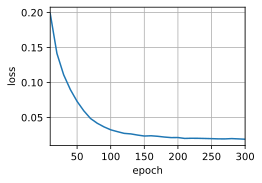

In [30]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

预测


In [31]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']] # 转成一个编码的序列
    
    enc_valid_len = torch.tensor([len(src_tokens)], device=device) # 记录有效程度
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>']) # 做截断和扩充
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0) # 转为张量,并添加一个维度变为 1,time
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    dec_X = torch.unsqueeze(
        torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device),
        dim=0) # 解码器的初始输入是<bos>
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps): # dec_x形状为1,1 batch,time
        Y, dec_state = net.decoder(dec_X, dec_state) # Y的形状是1,1,vocabSize
        dec_X = Y.argmax(dim=2) # 取概率最大的词作为下一个输入 形状1,1
        pred = dec_X.squeeze(dim=0).type(torch.int32).item() # 取标量
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq # 注意力权重

BLEU代码实现

In [32]:
def bleu(pred_seq, label_seq, k):  
    """计算 BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1): # 计算n-gram
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i:i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i:i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i:i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

翻译成法语

In [33]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai pigé le ., bleu 0.000
he's calm . => il est paresseux ., bleu 0.658
i'm home . => je suis refuse ., bleu 0.512


## 束搜索
在seq2seq中我们使用了贪心搜索来预测序列,将当前时刻预测概率最大的词输出<br>
但贪心很可能不是最优<br>

<img src='./image/greedAlgorithm.jpg' alt='greedAlgorithm' width=400><br>

### 穷举算法
最佳算法: 对所有可能的序列, 计算它的概率, 然后选取最好的哪个<br>
如果输出字典大小为$n$, 序列最长为$T$, 那么我们需要考察$n^T$个序列
* $n = 10000, T = 10 : n^T=10^40$
* 计算上不可行
  
### 束搜索
保存最好的k个候选<br>
在每个时刻,对每个候选新加一项(n种可能), 在kn个选项中选出最好的k个<br>
<img src='./image/beemSearch.jpg' alt='beemSearch' width=400><br>
时间复杂度$O(knT)$<br>
* $k=5, n=10000, T=10: knT=5 \times 10^5$

每个候选的最终分数是:<br>
$$\frac {1}{L^\alpha} \log p(y_1,...,y_L) = \frac {1}{L^\alpha} \sum ^L_{t'=1} \log p(y_t'|y_1,...,y_L) $$
通常$\alpha = 0.75$<br>

束搜索在每次搜索时保存k个最好的候选:
* k=1 时是贪心搜索
* k=n 时是穷举


